In [1]:
import numpy as np 
import pandas as pd
import os

from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback

import glob
from tqdm.auto import tqdm
from plotnine import *

In [2]:
infodf = pd.read_csv('/kaggle/input/10-none/data/info.csv')


In [3]:
infodf = infodf.drop('Unnamed: 0',axis = 1)

In [4]:
infodf

filename  class
0      151000120      9
1      151000220      9
2      151000320      9
3      151000420      9
4      151000520      9
...          ...    ...
23995  201239617      6
23996  201239717      6
23997  201239817      6
23998  201239917      6
23999  201240017      6

[24000 rows x 2 columns]

In [5]:
df = infodf
N = len(df)
import random
test_index =random.sample(range(N), int(N*0.3))
train_index = list(set(range(N))-set(test_index))
rows = df.index[test_index]
df_test = df.take(rows)
rows = df.index[train_index]
df_train = df.take(rows)
df_test.to_csv('test.csv')
df_train.to_csv('train.csv')

In [6]:
ftrain_df = pd.DataFrame({'filename':df_train['filename'],'path': ['/kaggle/input//10-none/data/image/'+str(ii)+'.png' for ii in df_train['filename']]})

In [7]:
train=df_train.merge(ftrain_df)

class=0


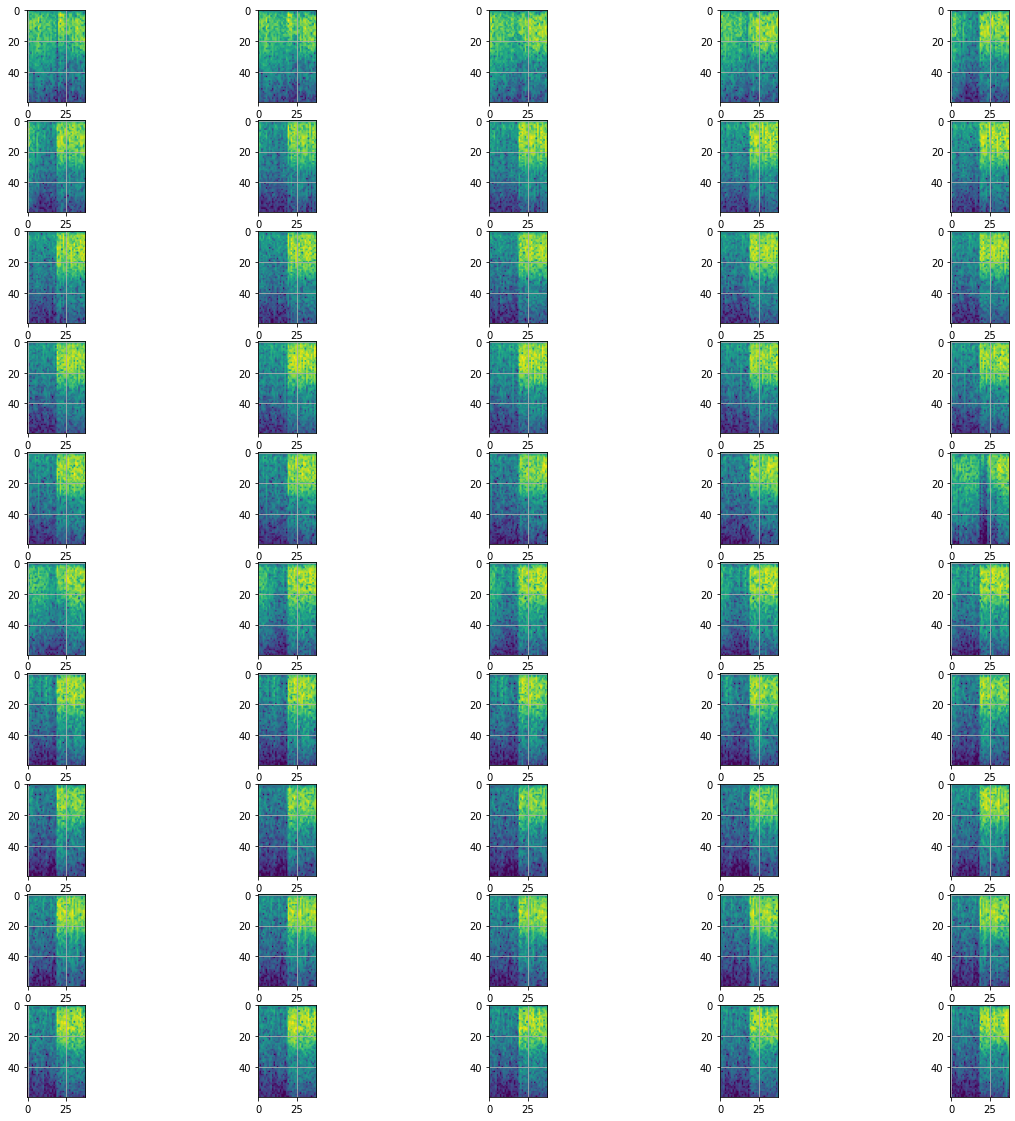

In [8]:
n = 0
print('class=0')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=1


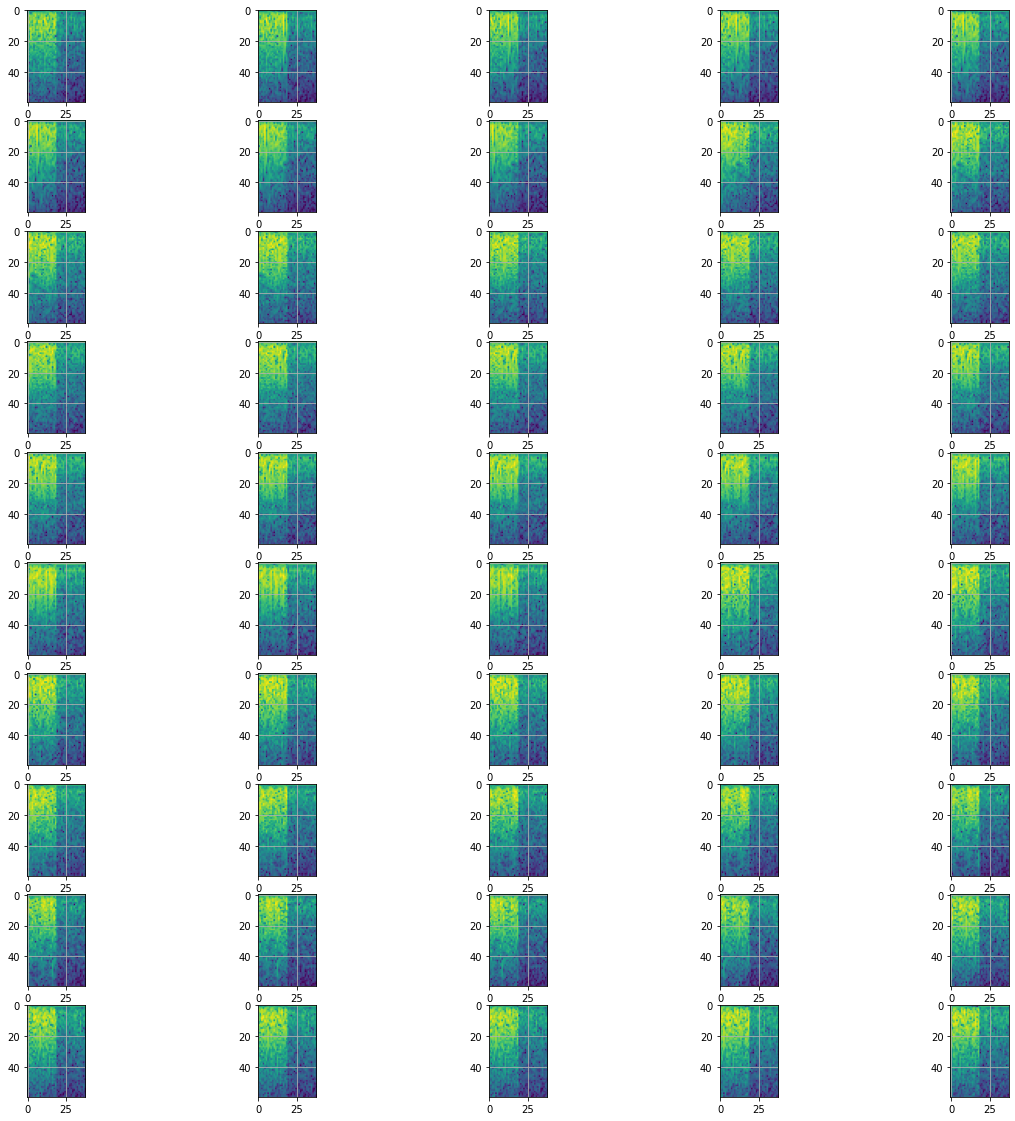

In [9]:
n = 1
print('class=1')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=2


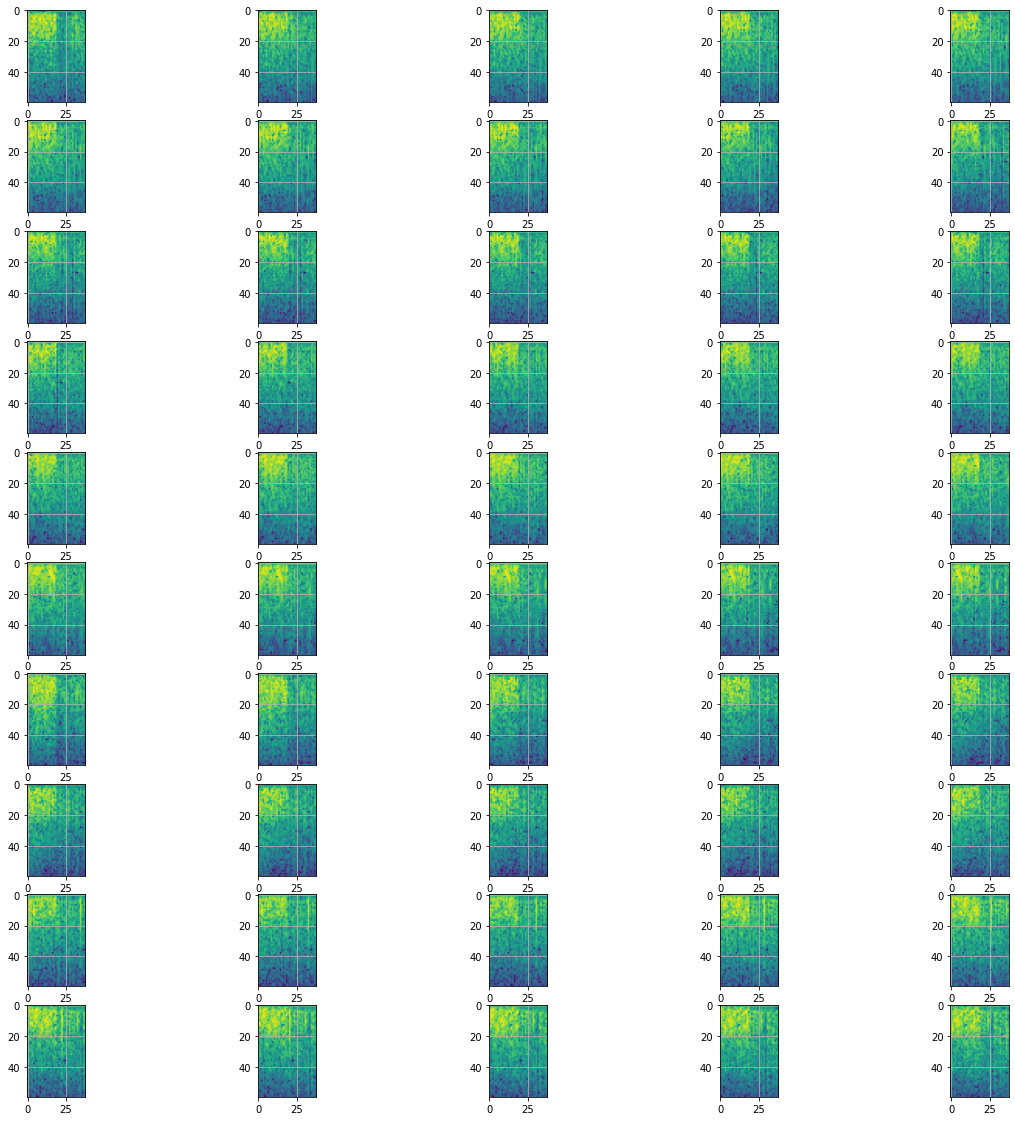

In [10]:
n = 2
print('class=2')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=3


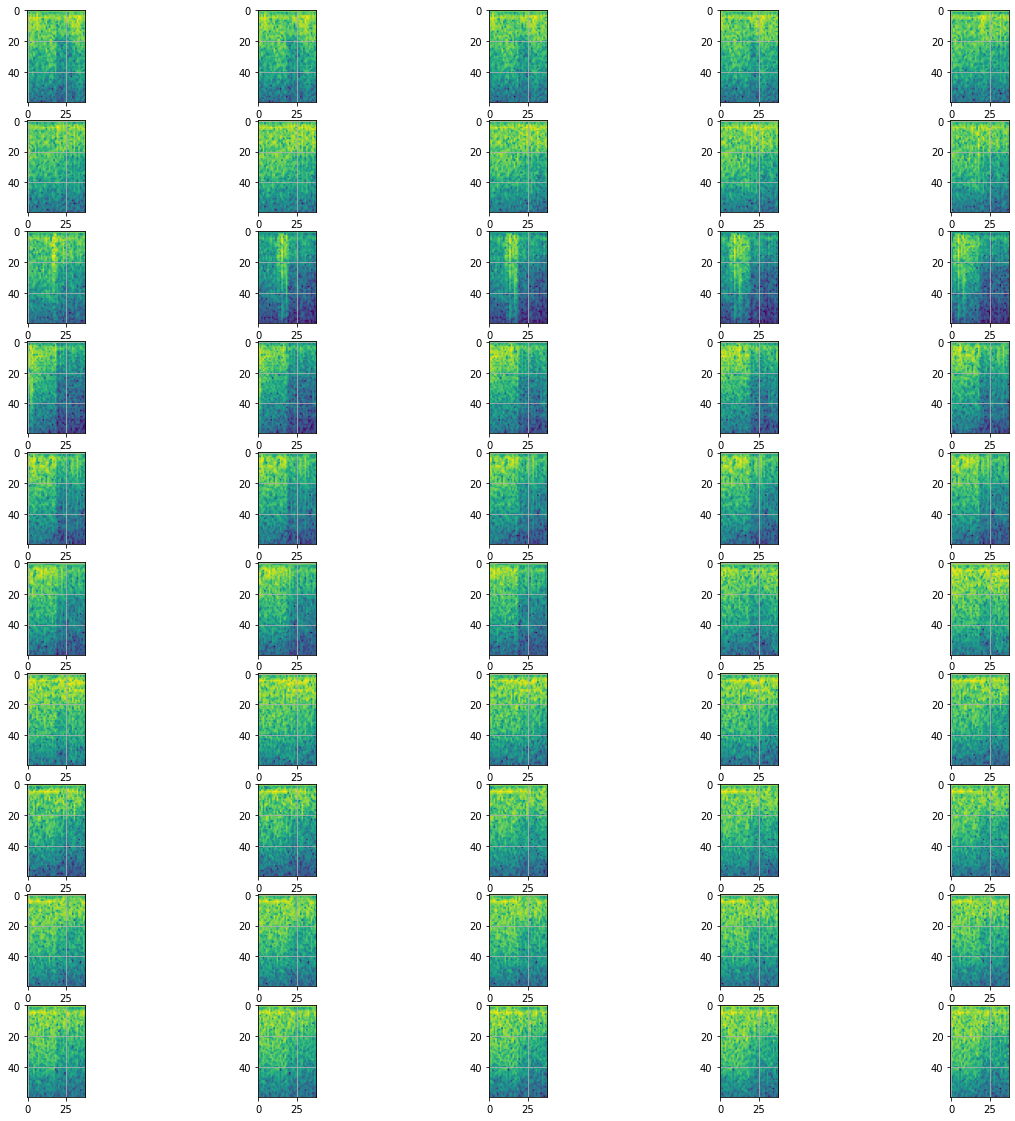

In [11]:
n = 3
print('class=3')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=4


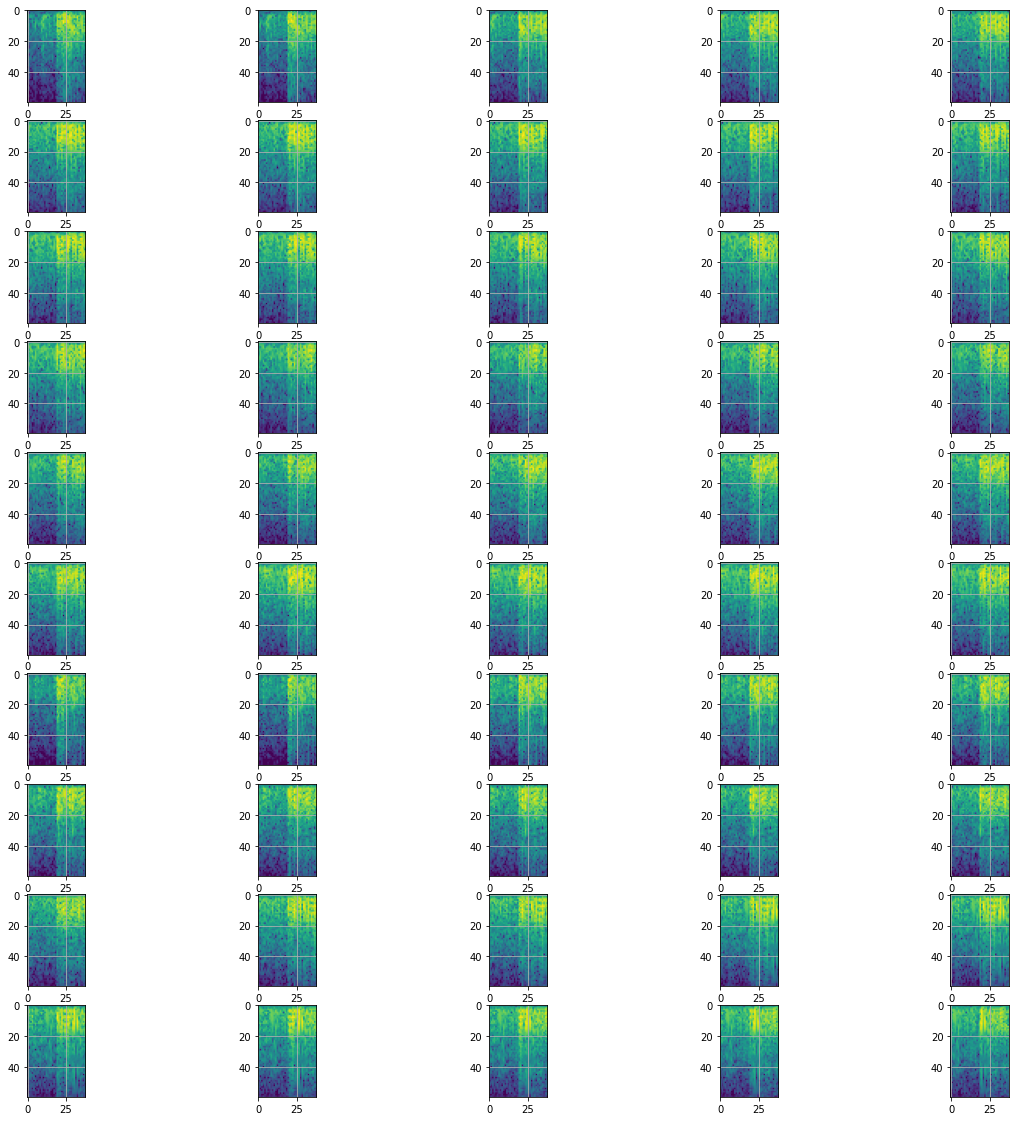

In [12]:
n = 4
print('class=4')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=5


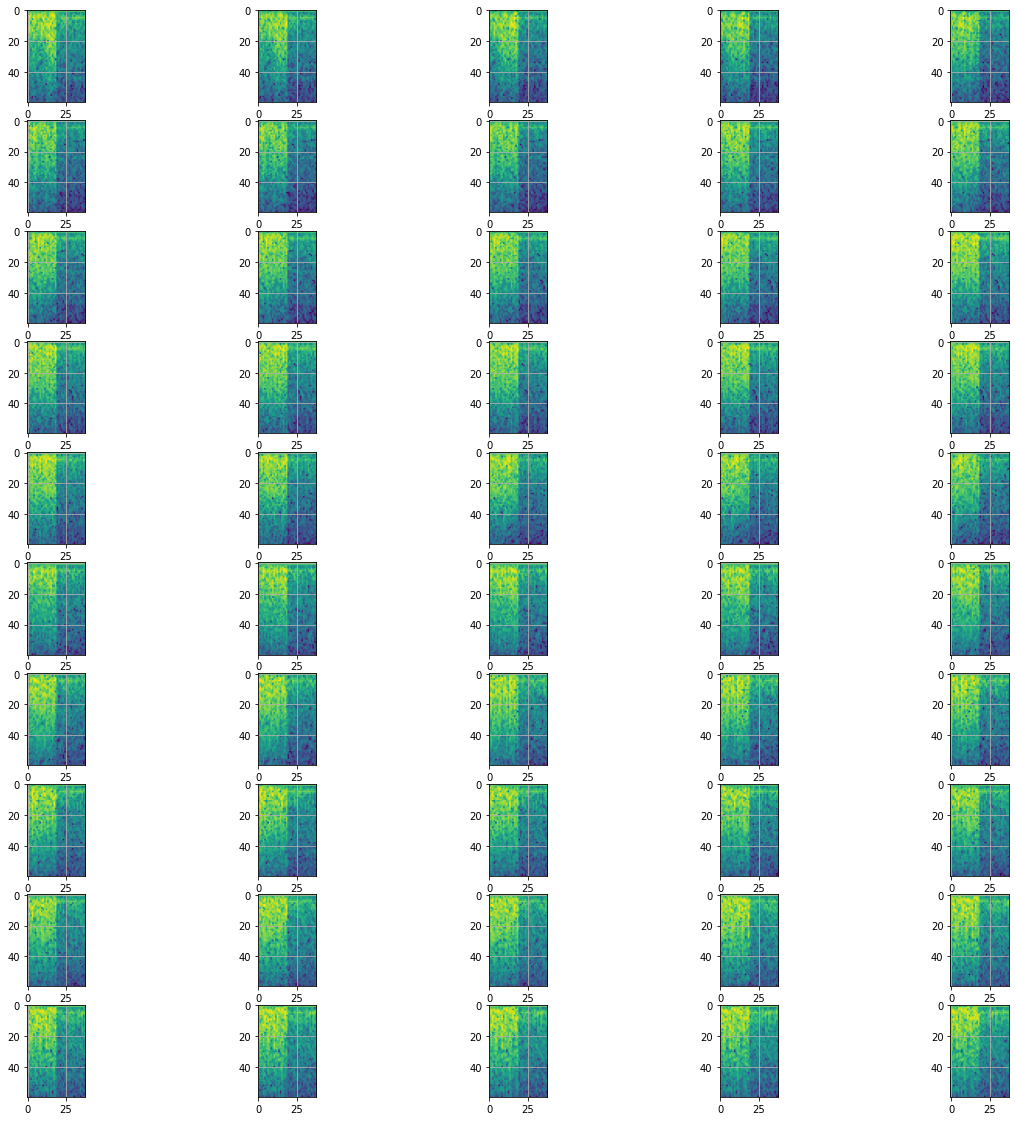

In [13]:
n = 5
print('class=5')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

In [14]:
train

filename  class                                             path
0      151000120      9  /kaggle/input//10-none/data/image/151000120.png
1      151000220      9  /kaggle/input//10-none/data/image/151000220.png
2      151000320      9  /kaggle/input//10-none/data/image/151000320.png
3      151000520      9  /kaggle/input//10-none/data/image/151000520.png
4      151000620      9  /kaggle/input//10-none/data/image/151000620.png
...          ...    ...                                              ...
16795  201239617      6  /kaggle/input//10-none/data/image/201239617.png
16796  201239717      6  /kaggle/input//10-none/data/image/201239717.png
16797  201239817      6  /kaggle/input//10-none/data/image/201239817.png
16798  201239917      6  /kaggle/input//10-none/data/image/201239917.png
16799  201240017      6  /kaggle/input//10-none/data/image/201240017.png

[16800 rows x 3 columns]

In [15]:
splitter=RandomSplitter(valid_pct=0.2, seed=42)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_x=ColReader(2), #x is stored in column 2
    get_y=ColReader(1), #y is stored in column 1
    splitter=splitter, #use parent folder as train-valid split
    )
dls = dblock.dataloaders(train, path='.', bs=64)

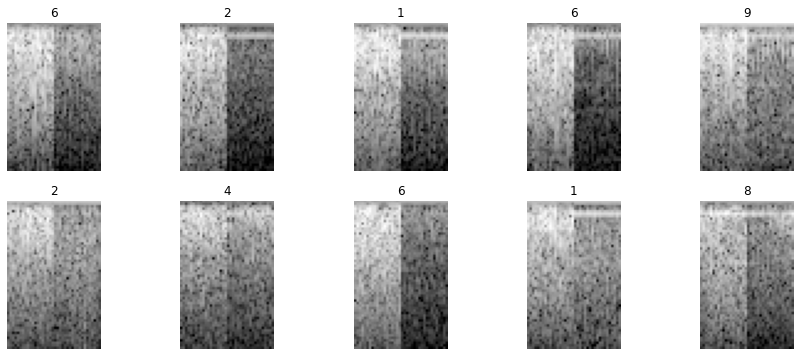

In [16]:
dls.train.show_batch(max_n=10, nrows=2)

In [17]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy,]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=7.585775847473997e-07)

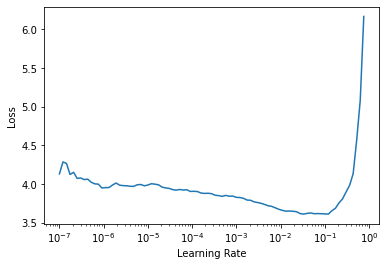

In [18]:
learn.lr_find()

In [19]:
#finetune 
learn.fine_tune(epochs=10,
          base_lr=1e-2, #max lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with max lr at base_lr/lr_mult
          pct_start=0.2, #start decreasing lr at 
          div=5.0, #start at base_lr (max lr) / div
          cbs=[SaveModelCallback(monitor='accuracy'),]
#               WandbCallback(), #track to wandb] #monitor accuracy and save best model
          )

Better model found at epoch 0 with accuracy value: 0.2883928716182709.


Better model found at epoch 0 with accuracy value: 0.643750011920929.
Better model found at epoch 1 with accuracy value: 0.8065476417541504.
Better model found at epoch 2 with accuracy value: 0.9014880657196045.
Better model found at epoch 3 with accuracy value: 0.9279761910438538.
Better model found at epoch 4 with accuracy value: 0.9440476298332214.
Better model found at epoch 5 with accuracy value: 0.9639880657196045.
Better model found at epoch 6 with accuracy value: 0.9764881134033203.
Better model found at epoch 7 with accuracy value: 0.9848214387893677.
Better model found at epoch 8 with accuracy value: 0.992559552192688.


In [20]:
learn.export()

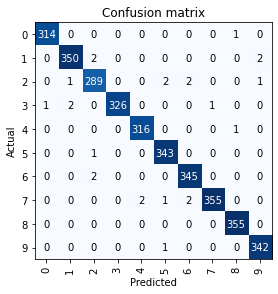

In [21]:
#see validation performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

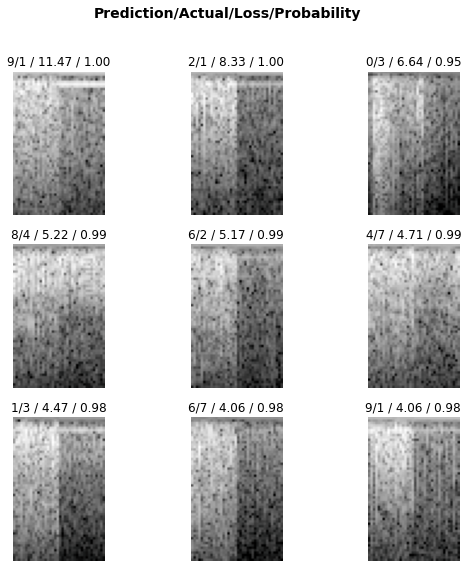

In [22]:
interp.plot_top_losses(9, nrows=3)

In [23]:
ftest_df = pd.DataFrame({'filename':df_test['filename'],'path': ['/kaggle/input//10-none/data/image/'+str(ii)+'.png' for ii in df_test['filename']]})

In [24]:
test=df_test.merge(ftest_df)

In [25]:
test

filename  class                                             path
0     191093213      2  /kaggle/input//10-none/data/image/191093213.png
1     111043518      7  /kaggle/input//10-none/data/image/111043518.png
2     191094216      5  /kaggle/input//10-none/data/image/191094216.png
3     111026317      6  /kaggle/input//10-none/data/image/111026317.png
4     191091011      0  /kaggle/input//10-none/data/image/191091011.png
...         ...    ...                                              ...
7195  181169215      4  /kaggle/input//10-none/data/image/181169215.png
7196  121202419      8  /kaggle/input//10-none/data/image/121202419.png
7197  111035316      5  /kaggle/input//10-none/data/image/111035316.png
7198  191094916      5  /kaggle/input//10-none/data/image/191094916.png
7199  111032114      3  /kaggle/input//10-none/data/image/111032114.png

[7200 rows x 3 columns]

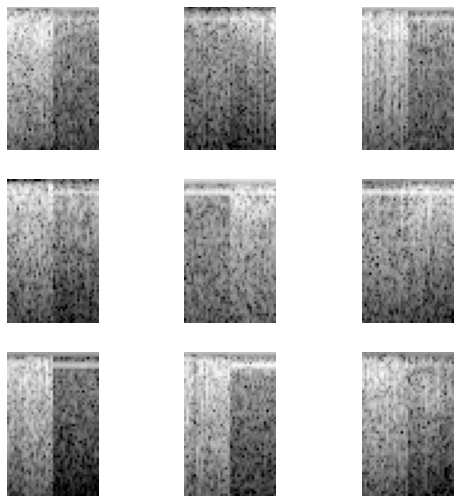

In [26]:
# test_fnames = get_image_files("/kaggle/input/emg-png/data/test/")
test_fnames = test['path']
len(test_fnames)
#create test dataloader
tst_dl = dls.test_dl(test_fnames,shuffle=False)
tst_dl.show_batch(max_n=9)

In [27]:
preds = learn.get_preds(dl=tst_dl) # get prediction logits
pred_idxs = preds[0].argmax(1) # get index with highest logit
pred_labs = [learn.dls.train_ds.vocab[i] for i in pred_idxs] #convert index to labels
pred_labs[:10]

[2, 7, 5, 6, 0, 3, 2, 7, 0, 8]

In [28]:
#put in dataframe
pred = pd.DataFrame({'fname':test_fnames,'Predicted':pred_labs})
pred['filename'] = pred.fname.map(lambda x: str(x)[-13:-4])
pred = pred[['filename','Predicted']].sort_values('filename').reset_index(drop=True)
pred.tail()

filename  Predicted
7195  201239911          0
7196  201239919          8
7197  201240011          0
7198  201240018          7
7199  201240020          9

In [29]:
pred.to_csv('/kaggle/working/predict.csv',index=False)
pred.head()

filename  Predicted
0  111024115          4
1  111024119          8
2  111024211          0
3  111024212          1
4  111024213          2

In [30]:
test['filename'] = test['filename'].astype(str)
test=test.merge(pred)
test.head()

filename  class                                             path  \
0  191093213      2  /kaggle/input//10-none/data/image/191093213.png   
1  111043518      7  /kaggle/input//10-none/data/image/111043518.png   
2  191094216      5  /kaggle/input//10-none/data/image/191094216.png   
3  111026317      6  /kaggle/input//10-none/data/image/111026317.png   
4  191091011      0  /kaggle/input//10-none/data/image/191091011.png   

   Predicted  
0          2  
1          7  
2          5  
3          6  
4          0

In [31]:
test['diff']=test['class']==test['Predicted']
test.head()

filename  class                                             path  \
0  191093213      2  /kaggle/input//10-none/data/image/191093213.png   
1  111043518      7  /kaggle/input//10-none/data/image/111043518.png   
2  191094216      5  /kaggle/input//10-none/data/image/191094216.png   
3  111026317      6  /kaggle/input//10-none/data/image/111026317.png   
4  191091011      0  /kaggle/input//10-none/data/image/191091011.png   

   Predicted  diff  
0          2  True  
1          7  True  
2          5  True  
3          6  True  
4          0  True

In [32]:
test['diff'].value_counts()

True     7140
False      60
Name: diff, dtype: int64

In [33]:
a = test['diff'].value_counts()[True]*100/(test['diff'].value_counts()[True]+test['diff'].value_counts()[False])
print('Accuracy:'+"{:.2f}".format(a)+'%')

Accuracy:99.17%


In [34]:
for ii in range(10):
    a, b = test['diff'].iloc[np.where(test['class']==ii)].value_counts()
    print('Accuracy Class ',ii,':'+"{:.2f}".format(100*a/(a+b))+'%')

Accuracy Class  0 :99.72%
Accuracy Class  1 :98.18%
Accuracy Class  2 :98.49%
Accuracy Class  3 :98.50%
Accuracy Class  4 :99.29%
Accuracy Class  5 :99.86%
Accuracy Class  6 :99.72%
Accuracy Class  7 :99.04%
Accuracy Class  8 :99.86%
Accuracy Class  9 :99.01%
